Import libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path

In [12]:
try:
    base_dir = Path(__file__).resolve().parent.parent
except NameError:
    base_dir = Path().resolve()

Importing data

In [13]:
output_dir = base_dir / "data" / "final"
df = pd.read_csv(output_dir / "3_bert_vectors_with_eco_grades_test.csv")
X = df.drop(columns=['ecoscore_grade']).values

1a. PCA Explained Variance - finding number that explains 95% variance

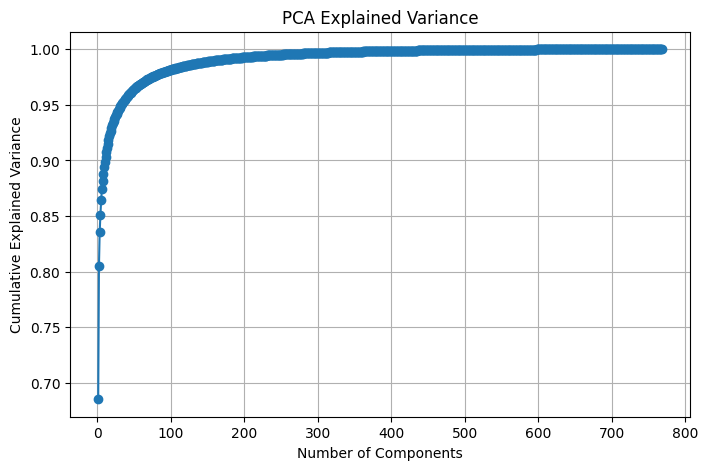

Number of components to explain 95% variance: 33


In [14]:
# X is my data matrix that contains the BERT embeddings
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# To find the number of components for 95% variance:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components_95}")

1b. PCA Dimensionality Reduction

In [15]:
# Fit PCA and transform
pca = PCA(n_components=33)
X_pca_34 = pca.fit_transform(X)

# Create a DataFrame with the 34 components
pca_columns = [f'pca_{i+1}' for i in range(33)]
df_pca = pd.DataFrame(X_pca_34, columns=pca_columns)

# Add ecoscore_grade column
df_pca['ecoscore_grade'] = df['ecoscore_grade'].values

# Defining X and y for modeling:
X = df_pca.drop('ecoscore_grade', axis=1)
y = df_pca['ecoscore_grade']

# Now df_pca contains only the 33 principal components + label, ready for classification

2a. KNN Hyperparameter Tuning - Elbow Method for n_neighbor value

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

2b. KNN Hyperparameter Tuning - GridSearchCV for other KNN parameters

In [17]:
# Modify parameter grid to prevent overfitting
param_grid = {
    'n_neighbors': range(5, 51, 2),  # Increased range for k
    'weights': ['uniform'],           # Simplified weight scheme
    'metric': ['minkowski'],          # Standard distance metric
    'p': [1, 2],                        # Euclidean distance
}

# Initialise and fit GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use best model for predictions
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

label_order = ['a-plus', 'a', 'b', 'c', 'd', 'e', 'f'] 

# Evaluate model performance
print("Best parameters:", grid_search.best_params_)
print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Cross-validation accuracy:", grid_search.best_score_)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, labels=label_order))

Best parameters: {'metric': 'minkowski', 'n_neighbors': 23, 'p': 1, 'weights': 'uniform'}
Training accuracy: 0.4216417910447761
Cross-validation accuracy: 0.34328358208955223
Test accuracy: 0.35522388059701493
              precision    recall  f1-score   support

      a-plus       0.00      0.00      0.00         0
           a       0.42      0.48      0.44        67
           b       0.26      0.30      0.28        67
           c       0.34      0.37      0.35        67
           d       0.42      0.28      0.34        67
           e       0.37      0.34      0.36        67
           f       0.00      0.00      0.00         0

   micro avg       0.36      0.36      0.36       335
   macro avg       0.26      0.25      0.25       335
weighted avg       0.36      0.36      0.35       335



c:\Users\megan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\megan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\megan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

2d. KNN - Confusion Matrix

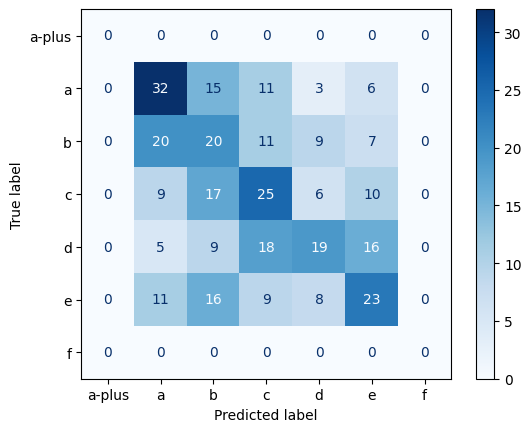

In [18]:
# Defining label order, with 'a-plus' first
label_order = ['a-plus', 'a', 'b', 'c', 'd', 'e', 'f']  

# y_test: true labels, y_pred: predicted labels
cm = confusion_matrix(y_test, y_test_pred, labels=label_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
disp.plot(cmap='Blues')

5a. Random Forest Classifier Hyperparameter Tuning

In [ ]:
# Define a reduced, randomized hyperparameter space
param_dist = {
    'n_estimators': randint(100, 300),               # Range of 100 to 300 trees
    'max_depth': [None, 10, 20, 30],                 # Depths to try
    'min_samples_split': [2, 5, 10],                 # Splits
    'min_samples_leaf': [1, 2, 4],                   # Leaf nodes
    'max_features': ['sqrt', 'log2', None],          # Feature selection strategies
    'bootstrap': [True, False],                      # Sampling method
    'criterion': ['gini', 'entropy']                 # Splitting criteria
}

# Define model
rf = RandomForestClassifier(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                    # Try 50 random combinations
    cv=5,                         # 5-fold cross-validation
    scoring='accuracy',          # You can change to 'f1_macro' for imbalanced classes
    n_jobs=-1,                    # Use all CPU cores
    verbose=1,                    # Print progress
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Evaluate
y_pred = random_search.predict(X_test)
print("Best Parameters Found:\n", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters Found:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 147}
Best Cross-Validated Accuracy: 0.3475687943262411

Classification Report on Test Set:
               precision    recall  f1-score   support

           a       0.30      0.24      0.26        67
      a-plus       0.44      0.55      0.49        67
           b       0.34      0.39      0.36        67
           c       0.25      0.21      0.23        67
           d       0.36      0.39      0.37        67
           e       0.31      0.25      0.28        67
           f       0.51      0.57      0.54        67

    accuracy                           0.37       469
   macro avg       0.36      0.37      0.36       469
weighted avg       0.36      0.37      0.36       469



<b>References</b>

Random Forest Classifier
https://www.simplilearn.com/tutorials/machine-learning-tutorial/random-forest-algorithm#:~:text=A%20Random%20Forest%20Algorithm%20is%20a%20supervised,more%20trees%20more%20it%20will%20be%20robust. 

BERT
https://airbyte.com/data-engineering-resources/bert-vector-embedding